In [11]:
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import matplotlib.pyplot as plt
import sys, time, os

package_path = os.path.abspath('../../../dolphindes')
if package_path not in sys.path:
    sys.path.append(package_path)

from dolphindes import photonics
import dolphindes.maxwell as maxwell

In [7]:
def comp_domain_setup(comm_x, comm_y, comm_rec_sep, rec_x, rec_y, dl, wvlgth=1.0, pml_sep=0.5, pml_thick=0.5):
    """
    setup up the computational domain, various masks, and Maxwell Greens function
    """
    Cx = int(np.round(comm_x / dl))
    Cy = int(np.round(comm_y / dl))
    CRsep = int(np.round(comm_rec_sep / dl))
    Rx = int(np.round(rec_x / dl))
    Ry = int(np.round(rec_y / dl))
    
    Npmlsep = int(np.round(pml_sep / dl))
    Npml = int(np.round(pml_thick / dl))

    Nx = Cx + CRsep + Rx + 2*(Npmlsep+Npml)
    Ny = max(Cy, Ry) + 2*(Npmlsep+Npml)

    Cx_start = Npml+Npmlsep
    Cy_start = (Ny - Cy) // 2
    comm_mask = np.zeros((Nx,Ny), dtype=bool)
    comm_mask[Cx_start:Cx_start+Cx , Cy_start:Cy_start+Cy] = True

    Rx_start = Cx_start + Cx + CRsep
    Ry_start = (Ny - Ry) // 2
    rec_mask = np.zeros((Nx,Ny), dtype=bool)
    rec_mask[Rx_start:Rx_start+Rx , Ry_start:Ry_start+Ry] = True

    ## get FDFD and Green's function
    omega = 2*np.pi/wvlgth
    FDFD = maxwell.TM_FDFD(omega, Nx, Ny, Npml, Npml, dl)
    G_RD = FDFD.get_TM_Gba(comm_mask, rec_mask)
    G_DD = FDFD.get_TM_Gba(comm_mask, comm_mask)
    return comm_mask, rec_mask, G_RD, G_DD

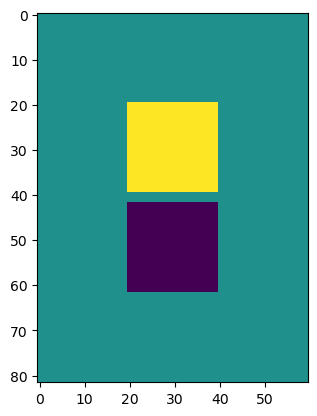

In [19]:
comm_x, comm_y, comm_rec_sep, rec_x, rec_y = 1.0, 1.0, 0.1, 1.0, 1.0
gpr = 20
dl = 1/gpr
wv = 1.0
num_angles = 2
direction = 'max'
which_singval = 0
comm_mask, rec_mask, G_RD, G_DD = comp_domain_setup(comm_x, comm_y, comm_rec_sep, rec_x, rec_y, 1/gpr, wv)
plt.imshow(comm_mask.astype(float) - rec_mask.astype(float))

In [14]:
def get_planewave_mats(phi_list, comm_mask, rec_mask, dl, wvlgth):
    """
    get the planewave sources over the metalens (comm) region and detector (receiver) region
    planewaves are specified by their signed angle phi with the x-axis
    """
    Nx, Ny = comm_mask.shape
    x_grid = dl*np.arange(Nx)
    y_grid = dl*np.arange(Ny)
    x_grid, y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')
    
    Q_D = np.zeros((int(np.sum(comm_mask)),len(phi_list)), dtype=complex)
    Q_R = np.zeros((int(np.sum(rec_mask)),len(phi_list)), dtype=complex)

    k = 2*np.pi / wvlgth
    for m,phi in enumerate(phi_list):
        kx = k*np.cos(phi)
        ky = k*np.sin(phi)
        wave_grid = np.exp(1j * (kx*x_grid + ky*y_grid))
        Q_D[:,m] = wave_grid[comm_mask]
        Q_R[:,m] = wave_grid[rec_mask]

    return Q_D, Q_R

In [15]:
Q_D, Q_R = get_planewave_mats(np.linspace(-np.pi/12, np.pi/12, num_angles), comm_mask, rec_mask, 1/gpr, wv)
U, S, Vh = la.svd(Q_R, full_matrices=False)
V = Vh.conj().T

In [18]:
if direction == 'max':
    V_subspace = V[:, which_singval:] # This is set up for bounding the singular values from above (maximum)
elif direction == 'min':
    V_subspace = V[:, :which_singval+1]

Grs = Q_R
Grd = G_RD
Gdd = G_DD
Gds = Q_D

In [ ]:
import dolphindes.util as util
import warnings
from dolphindes.cvxopt import qcqp

class custom_photonics(photonics.Photonics_TM_FDFD):
    def setup_QCQP(self, Pdiags: str = "global", verbose: float = 0) -> None:
        """
        Set up the quadratically constrained quadratic programming (QCQP) problem.

        This is a custom problem, in which the optimization variable x = [P, S],
        so there is no linear component. 
        
        Parameters
        ----------
        Pdiags : str or np.ndarray, optional
            Specification for projection matrix diagonals. If "global", creates
            global projectors with ones and -1j entries. Default: "global"
        verbose : float, optional
            Verbosity level for debugging output. Default: 0
            
        Notes
        -----        
        For sparse QCQP, creates SparseSharedProjQCQP with transformed matrices.
        For dense QCQP, creates DenseSharedProjQCQP with original matrices.
        
        Raises
        ------
        AttributeError
            If required attributes (des_mask, A0, s0, c0) are not defined.
        ValueError
            If neither ji nor ei is specified, or if Pdiags specification is invalid.
        """
        util.check_attributes(self, 'des_mask', 'A0', 's0', 'c0')
        
        # number of field degrees of freedom / pixels in design region
        self.Ndes = int(np.sum(self.des_mask)) 
        
        # generate initial field
        if (self.ji is None) and (self.ei is None):
            raise AttributeError("an initial current ji or field ei must be specified.")
        if not (self.ji is None) and not (self.ei is None):
            warnings.warn("If both ji and ei are specified then ji is ignored.")
        
        self.get_ei(self.ji, update=True)

        if Pdiags == "global":
            self.Pdiags = np.ones((self.Ndes,2), dtype=complex)
            self.Pdiags[:,1] = -1j
        else:
            raise ValueError("Not a valid Pdiags specification / needs implementation")
        
        if self.sparseQCQP: # rewrite later when sparse and dense QCQP classes are unified
            raise ValueError("Sparse QCQP not possible for this example")
        else:
            if self.G is None: 
                self.setup_EM_operators()
            
            A1_dense = np.conj(1.0/self.chi)*np.eye(self.G.shape[0]) - self.G.conj().T
            A1_dense 
            A2_dense = sp.eye(self.G.shape[0]*2)
            s1 = np.zeros((self.G.shape[0]*2,), dtype=complex)

            self.QCQP = qcqp.DenseSharedProjQCQP(self.A0, self.s0, self.c0,
                                            A1_dense, self.ei[self.des_mask]/2,
                                            self.Pdiags, verbose=verbose
                                            ) # for dense QCQP formulation A2 is not needed 

In [ ]:

Nd = Grd.shape[1]
Ns = Grs.shape[1]
A0 = np.zeros((Ns + Nd, Ns + Nd), dtype=complex)
A0[0:Nd, 0:Nd] = Grd.T.conj() @ Grd 
A0[Nd:, Nd:] = V_subspace.T.conj() @ Grs.T.conj() @ Grs @ V_subspace
A0[Nd:, 0:Nd] = V_subspace.T.conj() @ Grs.T.conj() @ Grd 
A0[0:Nd, Nd:] = A0[Nd:, 0:Nd].conj().T
direction_factor = 1 if direction == 'max' else -1
A0 *= dl**2 * -1 * direction_factor

s = np.zeros((Ns + Nd,), dtype=complex)
c = 0.0